## Compare SVC in the case of binary class (Sell, Buy)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)

In [2]:
# Get underlying prices
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [3]:
target = pd.read_csv("../data/processed/target_df.csv", index_col=0)["target"]

In [4]:
# Get the working dataframe
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [5]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [6]:
interest_rate = wk_df["r"].values

### Functions

In [7]:
def display_report(y_test: np.ndarray, predictions: np.ndarray) -> None:
    print(classification_report(y_test, predictions))
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()
    return

In [8]:
def plot_feature_imp(coefficients: np.ndarray[float], columns: list[str]) -> None:

    feature_importance = pd.DataFrame(
        {"Feature": columns, "Importance": np.abs(coefficients)}
    )
    feature_importance = feature_importance.sort_values("Importance", ascending=True)
    feature_importance.plot(x="Feature", y="Importance", kind="barh", figsize=(10, 6))
    plt.show()
    return

## Baseline SVC Classifier without new data + r

In [9]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [10]:
orig_df["r"] = interest_rate

### In sample predictions

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=True
)

In [12]:
params = {
    "random_state": 1968,
    "shrinking": False,
    "kernel": "poly",
    "gamma": "scale",
    "degree": 7,
    "C": 3.039195382313198,
} | {"verbose": 1}

In [13]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("rf", SVC(**params)),
    ]
)

In [14]:
# Fit the tuned model
pipe.fit(X_train, y_train)

[LibSVM]........*
optimization finished, #iter = 8454
obj = -2397.072005, rho = 0.399142
nSV = 864, nBSV = 796
Total nSV = 864


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('rf',
                 SVC(C=3.039195382313198, degree=7, kernel='poly',
                     random_state=1968, shrinking=False, verbose=1))])

In [15]:
predictions = pipe.predict(X_test)

In [16]:
pipe.score(X_test, y_test)

0.6095617529880478

              precision    recall  f1-score   support

           0       0.70      0.36      0.47       123
           1       0.58      0.85      0.69       128

    accuracy                           0.61       251
   macro avg       0.64      0.60      0.58       251
weighted avg       0.64      0.61      0.58       251



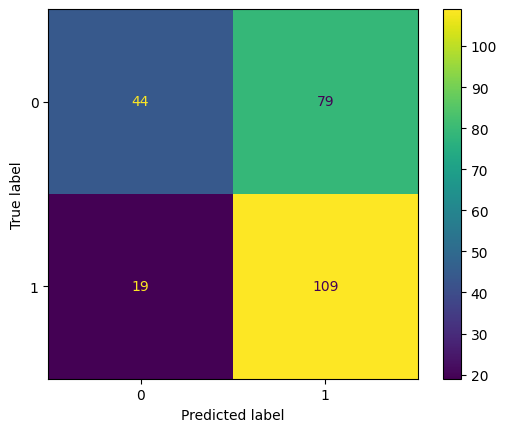

In [17]:
display_report(y_test, predictions)

In [18]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_in"])

### Backtesting

In [19]:
strategy = []
date_idx = []
prev_price = 0.0
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = X_test.iloc[-i, :].to_dict()
    quote_date = X_test.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [20]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

strategy_df = strategy_df.sort_index()

In [21]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [22]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2018-02-05,0,265.0,8.22,2018-02-28,271.649994,0.000000,-1.570006,0.000000,-1.570006
2018-02-22,1,270.0,4.26,2018-03-14,275.299988,1.039988,1.039988,1.039988,-0.530018
2018-03-08,1,274.0,2.85,2018-03-29,263.149994,-2.850000,-2.850000,-1.810012,-3.380018
2018-03-09,1,279.0,2.47,2018-03-29,263.149994,-2.470000,-2.470000,-4.280012,-5.850018
2018-04-03,1,260.5,5.09,2018-04-23,266.570007,0.980007,0.980007,-3.300005,-4.870011
...,...,...,...,...,...,...,...,...,...
2022-10-25,0,385.0,10.50,2022-11-14,395.119995,0.000000,-0.380005,501.809879,389.189830
2022-11-01,1,385.0,9.48,2022-11-21,394.589996,0.109996,0.109996,501.919875,389.299827
2022-11-02,1,375.0,10.19,2022-11-23,402.420013,17.230013,17.230013,519.149889,406.529840


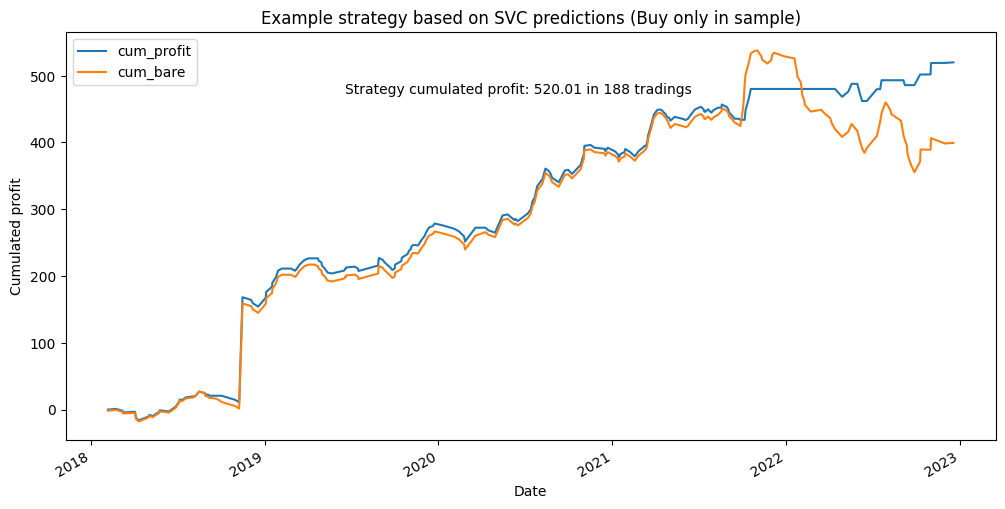

In [23]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on SVC predictions (Buy only in sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

### Out-of-sample predictions

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df.values,
    target.values.flatten(),
    test_size=0.2,
    random_state=1968,
    shuffle=False,
)

In [25]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("rf", SVC(**params)),
    ]
)

In [26]:
# Fit the tuned model
pipe.fit(X_train, y_train)

[LibSVM]...................................................................................................................................................................*
optimization finished, #iter = 163404
obj = -2476.555692, rho = 0.940187
nSV = 879, nBSV = 810
Total nSV = 879


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('rf',
                 SVC(C=3.039195382313198, degree=7, kernel='poly',
                     random_state=1968, shrinking=False, verbose=1))])

In [27]:
predictions = pipe.predict(X_test)

In [28]:
pipe.score(X_test, y_test)

0.4302788844621514

              precision    recall  f1-score   support

           0       0.66      0.39      0.49       177
           1       0.27      0.53      0.35        74

    accuracy                           0.43       251
   macro avg       0.46      0.46      0.42       251
weighted avg       0.55      0.43      0.45       251



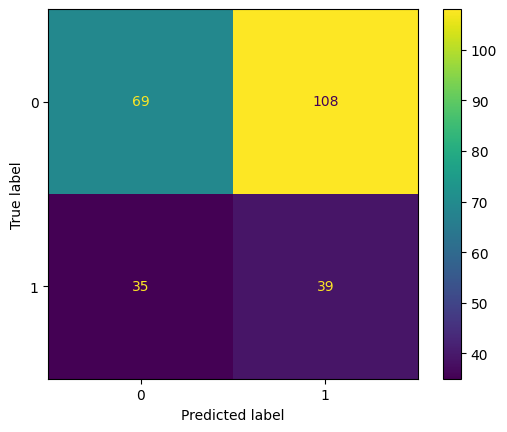

In [29]:
display_report(y_test, predictions)

In [30]:
compare_df["bare_rf_pred_out"] = predictions

### Backtest strategy

In [31]:
strategy = []
date_idx = []
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = orig_df.iloc[-i, :].to_dict()
    quote_date = orig_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    final_price = spy.loc[exp_date, "Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [32]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

In [33]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [34]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-01-03,0,478.0,4.81,2022-01-24,439.839996,0.00,-4.810000,0.000000,-4.810000
2022-01-04,0,478.0,4.80,2022-01-24,439.839996,0.00,-4.800000,0.000000,-9.610000
2022-01-05,0,468.0,8.14,2022-01-26,433.380005,0.00,-8.140000,0.000000,-17.750000
2022-01-06,0,468.0,7.00,2022-01-26,433.380005,0.00,-7.000000,0.000000,-24.750000
2022-01-07,0,466.0,7.56,2022-01-28,441.950012,0.00,-7.560000,0.000000,-32.310000
...,...,...,...,...,...,...,...,...,...
2022-12-23,0,383.0,8.00,2023-01-13,398.500000,0.00,7.500000,-379.560006,-525.980022
2022-12-26,1,383.0,7.96,2023-01-13,398.500000,7.54,7.540000,-372.020006,-518.440022
2022-12-28,0,377.0,8.75,2023-01-20,395.880005,0.00,10.130005,-372.020006,-508.310017


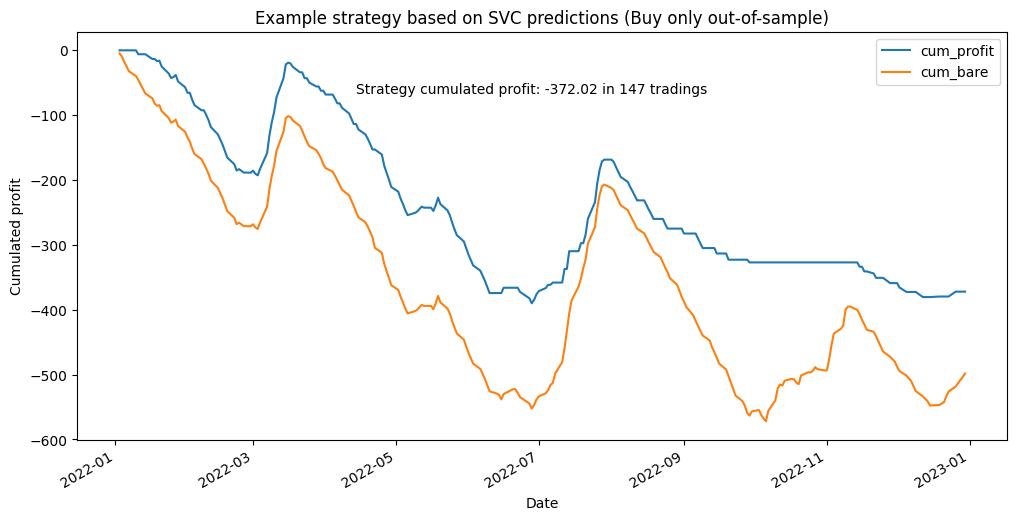

In [35]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on SVC predictions (Buy only out-of-sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

## SVC with data from MC simulation and additional features

In [36]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [37]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### In sample predictions

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df, target.values.flatten(), test_size=0.2, random_state=1968, shuffle=True
)

In [39]:
params = {
    "random_state": 1968,
    "shrinking": True,
    "kernel": "poly",
    "gamma": "scale",
    "degree": 8,
    "C": 5.736152510448681,
} | {"verbose": 1}

In [40]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("rf", SVC(**params)),
    ]
)

In [41]:
# Fit the tuned model
pipe.fit(X_train, y_train)

[LibSVM]......
*..*
optimization finished, #iter = 8065
obj = -4005.306863, rho = 0.501994
nSV = 853, nBSV = 710
Total nSV = 853


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('rf',
                 SVC(C=5.736152510448681, degree=8, kernel='poly',
                     random_state=1968, verbose=1))])

In [42]:
predictions = pipe.predict(X_test)

In [43]:
pipe.score(X_test, y_test)

0.6533864541832669

              precision    recall  f1-score   support

           0       0.79      0.40      0.53       123
           1       0.61      0.90      0.73       128

    accuracy                           0.65       251
   macro avg       0.70      0.65      0.63       251
weighted avg       0.70      0.65      0.63       251



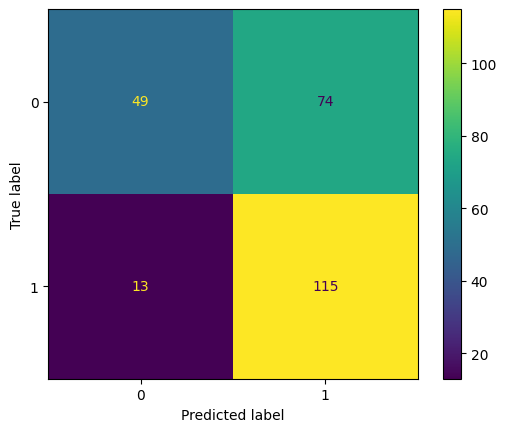

In [44]:
display_report(y_test, predictions)

In [45]:
compare_df["mmar_rf_pred_in"] = predictions

### Backtesting

In [46]:
strategy = []
date_idx = []
prev_price = 0.0
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = X_test.iloc[-i, :].to_dict()
    quote_date = X_test.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    # Needed since a day in YF is missing
    try:
        final_price = spy.loc[exp_date, "Close"]
    except:
        final_price = prev_price
    prev_price = final_price
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [47]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

strategy_df = strategy_df.sort_index()

In [48]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [49]:
strategy_df

,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,,
2018-02-05,1,265.0,8.22,4.942161,2018-02-28,271.649994,-1.570006,-1.570006,-1.570006,-1.570006
2018-02-22,1,270.0,4.26,6.397086,2018-03-14,275.299988,1.039988,1.039988,-0.530018,-0.530018
2018-03-08,1,274.0,2.85,5.917690,2018-03-29,263.149994,-2.850000,-2.850000,-3.380018,-3.380018
2018-03-09,1,279.0,2.47,5.505012,2018-03-29,263.149994,-2.470000,-2.470000,-5.850018,-5.850018
2018-04-03,1,260.5,5.09,5.247430,2018-04-23,266.570007,0.980007,0.980007,-4.870011,-4.870011
...,...,...,...,...,...,...,...,...,...,...
2022-10-25,0,385.0,10.50,9.062317,2022-11-14,395.119995,0.000000,-0.380005,564.689827,389.189830
2022-11-01,0,385.0,9.48,8.719475,2022-11-21,394.589996,0.000000,0.109996,564.689827,389.299827
2022-11-02,1,375.0,10.19,8.901524,2022-11-23,402.420013,17.230013,17.230013,581.919840,406.529840


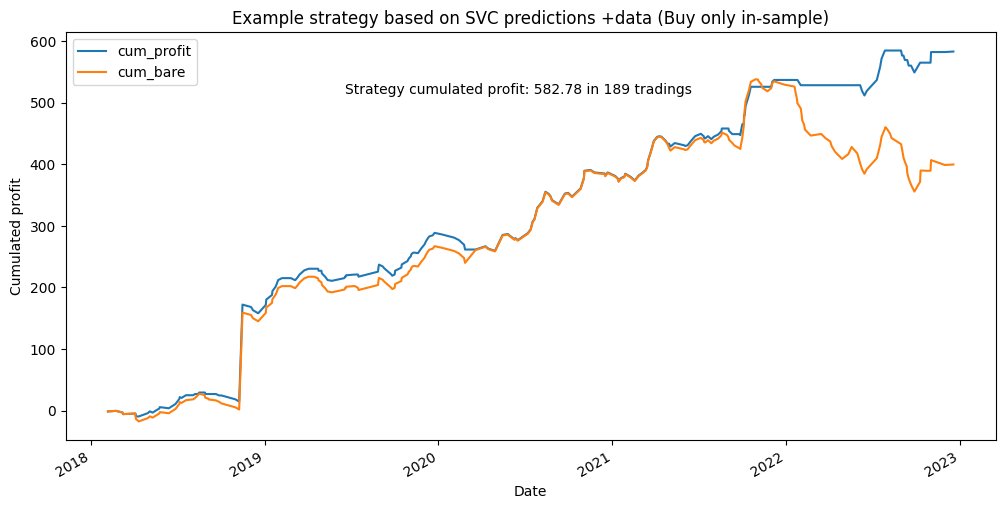

In [50]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on SVC predictions +data (Buy only in-sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

### Out-of-sample predictions

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df.values,
    target.values.flatten(),
    test_size=0.2,
    random_state=1968,
    shuffle=False,
)

In [52]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        ("scaler", StandardScaler()),
        ("rf", SVC(**params)),
    ]
)

In [53]:
# Fit the tuned model
pipe.fit(X_train, y_train)

[LibSVM]..................*
optimization finished, #iter = 18806
obj = -4130.655608, rho = 0.911212
nSV = 856, nBSV = 715
Total nSV = 856


Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('scaler', StandardScaler()),
                ('rf',
                 SVC(C=5.736152510448681, degree=8, kernel='poly',
                     random_state=1968, verbose=1))])

In [54]:
predictions = pipe.predict(X_test)

In [55]:
pipe.score(X_test, y_test)

0.44621513944223107

              precision    recall  f1-score   support

           0       0.64      0.49      0.56       177
           1       0.22      0.34      0.26        74

    accuracy                           0.45       251
   macro avg       0.43      0.41      0.41       251
weighted avg       0.52      0.45      0.47       251



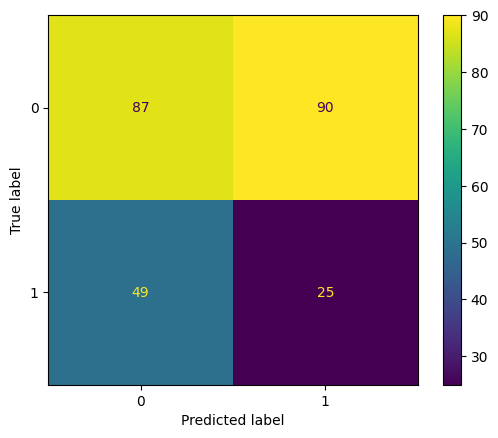

In [56]:
display_report(y_test, predictions)

In [57]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtest strategy

In [58]:
strategy = []
date_idx = []
for x, i in enumerate(range(len(predictions), 0, -1)):
    row = new_df.iloc[-i, :].to_dict()
    quote_date = new_df.index[-i]
    exp_date = pd.to_datetime(ml_df.loc[quote_date, "EXPIRE_DATE"])
    final_price = spy.loc[exp_date, "Close"]
    call_price = row["C_LAST"]
    strike = row["STRIKE"]
    if predictions[x]:  # buy
        if final_price > strike:
            profit = final_price - (strike + call_price)
        else:
            profit = -call_price
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": profit,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    else:
        res = {
            "strategy": predictions[x],
            "strike": strike,
            "call_price": row["C_LAST"],
            "exp_call": row["exp_call_price"],
            "exp_date": ml_df.loc[quote_date, "EXPIRE_DATE"],
            "final_price": final_price,
            "profit": 0.0,
            "bare": max(final_price - (strike + call_price), -call_price),
        }
    strategy.append(res)
    date_idx.append(quote_date)

In [59]:
strategy_df = pd.DataFrame(strategy, pd.Index(name="Date", data=date_idx))

In [60]:
strategy_df["cum_profit"] = np.cumsum(strategy_df.profit.values)
strategy_df["cum_bare"] = np.cumsum(strategy_df.bare.values)

In [61]:
strategy_df

,strategy,strike,call_price,exp_call,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,,
2022-01-03,1,478.0,4.81,10.248337,2022-01-24,439.839996,-4.810000,-4.810000,-4.810000,-4.810000
2022-01-04,0,478.0,4.80,9.610177,2022-01-24,439.839996,0.000000,-4.800000,-4.810000,-9.610000
2022-01-05,1,468.0,8.14,10.191128,2022-01-26,433.380005,-8.140000,-8.140000,-12.950000,-17.750000
2022-01-06,1,468.0,7.00,9.657596,2022-01-26,433.380005,-7.000000,-7.000000,-19.950000,-24.750000
2022-01-07,0,466.0,7.56,9.927762,2022-01-28,441.950012,0.000000,-7.560000,-19.950000,-32.310000
...,...,...,...,...,...,...,...,...,...,...
2022-12-23,1,383.0,8.00,8.453400,2023-01-13,398.500000,7.500000,7.500000,-368.990040,-525.980022
2022-12-26,1,383.0,7.96,8.096501,2023-01-13,398.500000,7.540000,7.540000,-361.450040,-518.440022
2022-12-28,1,377.0,8.75,8.526141,2023-01-20,395.880005,10.130005,10.130005,-351.320035,-508.310017


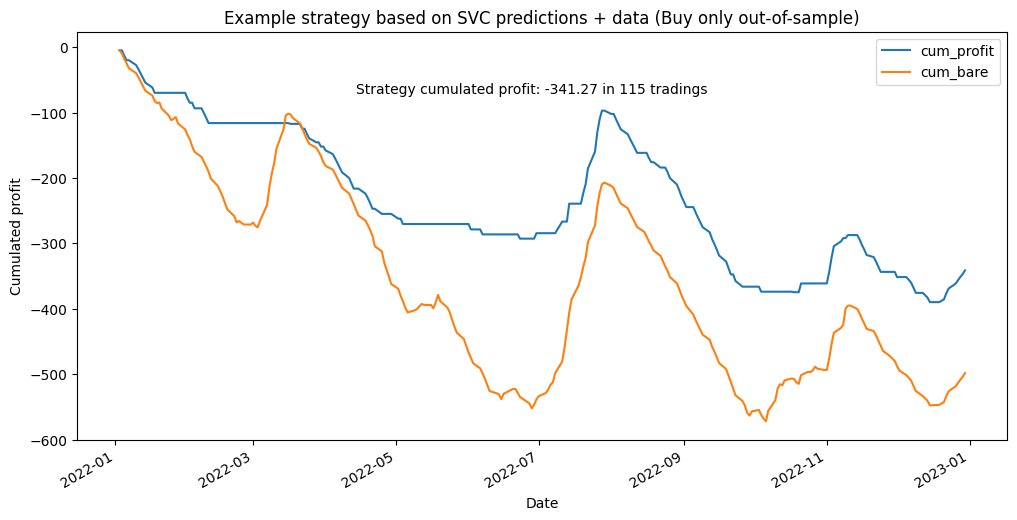

In [62]:
strategy_df[["cum_profit", "cum_bare"]].plot(
    figsize=(12, 6),
    ylabel="Cumulated profit",
    title="Example strategy based on SVC predictions + data (Buy only out-of-sample)",
)
ax = plt.gca()
text = f"Strategy cumulated profit: {strategy_df['cum_profit'].iloc[-1]:.2f} in {strategy_df['strategy'].sum()} tradings"
plt.text(0.3, 0.85, text, transform=ax.transAxes)
plt.legend()
plt.show()

## Compare the two predictions

In [63]:
mask_in = (compare_df["bare_rf_pred_in"] - compare_df["mmar_rf_pred_in"]).astype(bool)
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [64]:
# Compare in sample preds
compare_df[mask_in]

,bare_rf_pred_in,bare_rf_pred_out,mmar_rf_pred_in,mmar_rf_pred_out
2,0,0,1,1
6,1,1,0,1
8,0,0,1,1
21,1,1,0,1
24,1,1,0,1
26,0,0,1,1
32,1,1,0,0
38,1,1,0,0
40,0,1,1,0
51,1,1,0,0


In [65]:
compare_df[mask_in].shape

(37, 4)

In [66]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_in,bare_rf_pred_out,mmar_rf_pred_in,mmar_rf_pred_out
0,1,0,1,1
2,0,0,1,1
3,1,0,1,1
5,1,0,1,1
7,1,0,1,1
...,...,...,...,...
245,0,0,0,1
246,1,0,1,1
248,1,0,1,1
249,1,0,1,1


In [67]:
compare_df[mask_out].shape

(148, 4)

In [68]:
compare_df.sum(axis=0)

bare_rf_pred_in     188
bare_rf_pred_out    147
mmar_rf_pred_in     189
mmar_rf_pred_out    115
dtype: int64